## 2021 Amazon Last Mile Routing Research Challenge

**Dataset**

    aws s3 --no-sign-request cp s3://amazon-last-mile-challenges/almrrc2021/ ./data --recursive

Training data: /data/almrrc2021-data-training  \
Test data: /data/almrrc2021-data-evaluation

In [1]:
!pip install shapely

In [86]:
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 410.0 kB/s eta 0:00:00m eta 0:00:010:01:01
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [22]:
import json
from shapely.geometry.polygon import Polygon
import datetime as dt
import statistics
import pandas as pd

In [3]:
def load_data(filepath):
    try:
        with open(filepath, 'r') as fp:
            json_data = json.loads(fp.read())
        fp.close() 
        return json_data
    except FileNotFoundError:
        print("Missing file: %s", filepath)
    except Exception as e:
        print("Error trying to read file %s: %s", (pathfile, e))

In [4]:
def compute_area(points):
    polygon = Polygon(points)
    # the area in square degrees
    area = polygon.area
    return area

In [5]:
def is_between(time, time_range):
    if time_range[1] < time_range[0]:
        return time >= time_range[0] or time <= time_range[1]
    return time_range[0] <= time <= time_range[1]

In [6]:
def time_in_between(rush_hour, start_route, end_route):
    if (start_route < rush_hour[1] and end_route > rush_hour[0]) or (start_route > rush_hour[1] and end_route > rush_hour[0] and end_route < start_route) or (start_route < rush_hour[1] and (end_route < start_route)) or (rush_hour[0] < start_route < rush_hour[1]) or (rush_hour[0] < end_route < rush_hour[1]):
        return 1
    else:
        return 0

In [7]:
def isnan(value):
    try:
        import math
        return math.isnan(float(value))
    except:
        return False

In [39]:
"""
    Train/test features
    Adding new fetures to the original feature set
"""
def create_features(phase="build", features_file='./new_features.json'):
    # feature vector and labels
    all_features = []

    weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    times_of_the_day = ["00", "01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15",
                        "16", "17", "18", "19", "20", "21", "22", "23"]

    # stat_weekday_low = [0, 0, 0, 0, 0, 0, 0]
    # stat_weekday_high = [0, 0, 0, 0, 0, 0, 0]
    # stat_weekday_medium = [0, 0, 0, 0, 0, 0, 0]

    hour_low = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    hour_medium = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    hour_high = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


    """
    Features:
    routeID: route id
    route_size: route size (number of stops per route)
    total_delivery_time: route total time (distance + time for package delivery)
    travel_time: time to travel between stops (distance)
    violation_count: window violation count
    violation_avg_time: window violation average time (seconds)
    violation_total_time: window violation total time (seconds)
    ratio_violation_w_total_time: ratio between window violation time and window total time        
    violation_early_total_time: window violation total time - arrived early (time in seconds)
    violation_late_total_time: window violation total time - arrived late (time in seconds)
    violation_early_avg_time: window violation avg time - arrived early (time in seconds)
    violation_late_avg_time: window violation avg time - arrived late (time in seconds)
    violation_early_count:  window violation count - arrived early
    violation_late_count: window violation time - arrived late
    ratio_early_violation: ratio between window violation time and window total time - arrived early
    ratio_late_violation: ratio between window violation time and window total time - arrived late       
    zones_count: number of unique zones per route
    backtracking_count: backtracking count (number of times a driver leaves and then goes back to a zone) 
    ratio_backtracking_route_size: ratio between backtracking count and route size
    ratio_backtracking_route_zones: ratio between backtracking count and number of unique zones in a route

    ratio_delivery_time_stops: ratio between delivery time and number of stops
    ratio_zones_delivery_time: ratio between number of unique zones and delivery time 
    ratio_route_size_delivery_time: ratio between route size (number of stops) and delivery time
    ratio_packages_count_delivery_time: ratio between number of packages and delivery time
    ratio_violation_delivery_time: ratio between window violation count and delivery time (route size)
    ratio_delivery_time_stops: ratio between delivery time and number of stops (route size)
    ratio_delivery_time_packages_count: ratio between delivery time and number of packages

    ratio_travel_time_stops: ratio between travel time and number of stops        
    ratio_zones_route_size: ratio between number of unique zones and route size (number of stops per route)
    ratio_zones_travel_time: ratio between number of unique zones and travel time 
    ratio_route_size_travel_time: ratio between route size (number of stops) and travel time
    ratio_packages_count_travel_time: ratio between number of packages and travel time
    ratio_packages_count_route_size: ratio between number of packages and route size (number of stops per route)
    ratio_violation_travel_time: ratio between window violation count and travel time (route size)
    ratio_travel_time_stops: ratio between travel time and number of stops (route size)
    ratio_travel_time_packages_count: ratio between travel time and number of packages
    ratio_package_count_violation_avg_time: ratio between packages count and window violation total time
    ratio_package_count_violation_total_time: ratio between packages count (not delivered on time) and window 
    violation total time
    ratio_package_count_violation_late_avg_time: ratio between avg packages count (delivered late) and window 
    violation (late) average time
    ratio_package_count_violation_late_total_time: ration between total packages count (delivered late) and window 
    violation (late) total time
    ratio_package_volume_delivery_time: ratio between packages volume and delivery time
    ratio_package_volume_violation_time: ratio between packages volume (not delivered on time) and window violation 
    total time
    ratio_package_volume_violation_late_total_time: ratio between packages (not delivered on time) volume and window 
    violation (late) total time      
    rush_hour_morning (7am-9am): route went through morning rush hour
    rush_hour_evening (5pm-7pm): route went through evening rush hour  
    time of the day: hour_00, hour_01, hour_02, hour_03 ... hour_24
    Day of the week: monday, tuesday, wednesday, thursday, friday, saturday, sunday
    area: area of polygon using all (lat, lng) in one route 

    ratio_backtracking_travel_time: ration between backtracking count and travel time
    ratio_backtracking_delivery_time: ration between backtracking count and travel time

    # time between stops - statistics
    min_time_btw_stops
    max_time_btw_stops
    std_time_btw_stops
    median_time_btw_stops
    mean_time_btw_stops

    # packages per stop - statistics
    min_packages_per_stop 
    max_packages_per_stop
    std_packages_per_stop
    median_packages_per_stop
    mean_packages_per_stop

    # planned service time statistics
    min_planned_service_time
    max_planned_service_time
    std_planned_service_time
    median_planned_service_time
    mean_planned_service_time

    ratio_packages_planned_service: ratio between packages count and planned service time
    ratio_package_volume_planned_service: ratio between package volume and planned service time
    total_planned_service_time: total planned service time


    MISSING:
    distance: distance (km)
    ratio_distance_travel_time: ratio between distance and total travel time
    ratio_distance_route_size: ratio between distance and number of stops (average distance)
    ratio between avg distance between two stops and time window violation

    # Number of time the planned service time is greater than travel time between stops

    MAYBE:        
    One feature per zone - help to identify difficult routes
    Numero de vezes em que o planned service time 'e maior que o tempo de viagem entre os stops (e a razao)

    """
    # For each route, compute new features
    for routeID in route_data.keys():
        # create feature dictionary for each route
        features = {'routeID': routeID}
        # get route data
        route = route_data[routeID]
        route_date = route['date_YYYY_MM_DD']
        route_departure_time = route['departure_time_utc']
        # route_size: route size (number of stops per route)
        route_size = len(route["stops"].keys())
        features['route_size'] = route_size

        # combine attributes date_YYYY_MM_DD with departure_time_utc
        date = dt.datetime.strptime(route['date_YYYY_MM_DD'], '%Y-%m-%d')
        time = dt.datetime.strptime(route['departure_time_utc'], '%H:%M:%S').time()
        start_time = dt.datetime.combine(date, time)

        lat_lng = []

        # indicative variable for weekday
        for item in weekdays:
            if item == weekdays[date.weekday()]:
                features[item] = 1
            else:
                features[item] = 0

        # get actual sequence
        if phase == 'build':
            sequence = actual_sequences_data[routeID]['actual']
        else:  # phase = 'apply'
            sequence = actual_sequences_data[routeID]['proposed']
        sequence = sorted(sequence, key=sequence.get)
        # travel and delivery time variables
        travel_time = 0
        delivery_time = 0
        total_delivery_time = 0
        # time window for package delivery
        tw_violated = 0
        tw_violated_early = 0
        tw_violated_late = 0
        # time window difference when violated (total per route)
        difference = 0
        difference_early = 0
        difference_late = 0
        # time window for all stops (total em seconds)
        tw_total = 0
        # zones sequence
        zones = []
        backtracking = 0
        unique_zones = 0
        # packages count
        package_count = 0
        package_count_violation = 0
        package_count_total_violation = 0
        package_count_late_violation = 0
        # packages volume
        package_volume = 0
        package_volume_late_violation = 0
        # time between stops
        time_between_stops = []
        # packages per stop
        packages_stat_per_stop = []
        # planned service time statistics
        planned_service_time = []
        # getting lat and lng for the source station
        lat_lng.append((route['stops'][sequence[0]]['lat'], route['stops'][sequence[0]]['lng']))
        for index in range(0, len(sequence)-1):
            # variables used to check time window per stop
            tw_start = 0
            tw_end = 0
            has_time_window = False
            # travel time
            travel_time += travel_times_data[routeID][sequence[index]][sequence[index+1]]
            # saving time between each stop to build features at the end
            time_between_stops.append(travel_times_data[routeID][sequence[index]][sequence[index+1]])

            lat_lng.append((route['stops'][sequence[index + 1]]['lat'], route['stops'][sequence[index + 1]]['lng']))

            # total number of packages per stop
            packages_per_stop = 0
            # total volume of packages per stop
            package_volume_stop = 0
            # stop sequence[0] is the delivery station. There are no packages to be delivery at this stop.
            # compute time to delivery all packages from the same stop
            service_time = 0

            sort_packages = sorted(package_data[routeID][sequence[index+1]])
            for pkg in sort_packages:
                # counting total number of packages
                package_count += 1
                # counting number of packages in this stop
                packages_per_stop += 1
                # At this point, I am considering that planned_service_time_seconds is the same for all packages.
                if package_data[routeID][sequence[index+1]][pkg]['planned_service_time_seconds']:
                    service_time += package_data[routeID][sequence[index+1]][pkg]['planned_service_time_seconds']
                    planned_service_time.append(package_data[routeID][sequence[index+1]][pkg]['planned_service_time_seconds'])
                # if not (isinstance(package_data[routeID][sequence[index+1]][pkg]['time_window']['start_time_utc'], float) \
                #         and np.isnan(package_data[routeID][sequence[index+1]][pkg]['time_window']['start_time_utc'])):
                if not isnan(package_data[routeID][sequence[index+1]][pkg]['time_window']['start_time_utc']):
                    has_time_window = True

                    tw_start = dt.datetime.strptime(package_data[routeID][sequence[index+1]][pkg]['time_window']
                                                    ['start_time_utc'], '%Y-%m-%d %H:%M:%S')
                    tw_end = dt.datetime.strptime(package_data[routeID][sequence[index+1]][pkg]['time_window']
                                                  ['end_time_utc'], '%Y-%m-%d %H:%M:%S')
                # I am considering that if depth_cm exists, than height_cm and width_cm also exist.
                # if not (isinstance(package_data[routeID][sequence[index+1]][pkg]['dimensions']['depth_cm'], float) \
                #         and np.isnan(package_data[routeID][sequence[index+1]][pkg]['dimensions']['depth_cm'])):
                if not isnan(package_data[routeID][sequence[index+1]][pkg]['dimensions']['depth_cm']):
                    # package volume
                    package_volume_stop += (package_data[routeID][sequence[index+1]][pkg]['dimensions']['depth_cm']
                                            * package_data[routeID][sequence[index+1]][pkg]['dimensions']['height_cm']
                                            * package_data[routeID][sequence[index+1]][pkg]['dimensions']['width_cm'])

            # package data per stop - for statistics
            packages_stat_per_stop.append(packages_per_stop)

            # route total delivery time (packages)
            delivery_time += service_time

            # package volume per route
            package_volume += package_volume_stop

            # check time window for each stop:
            if has_time_window:
                # counting total number of packages with time window violation
                package_count_violation += packages_per_stop
                # time window for all stops (total em seconds)
                tw_total += (tw_end - tw_start).total_seconds()
                current_time = start_time + dt.timedelta(seconds=(travel_time + delivery_time))
                # if current time is not in the window, mark as a violation
                if not (tw_start <= current_time <= tw_end):
                    tw_violated += 1
                    package_count_total_violation += packages_per_stop
                    if current_time < tw_start:
                        tw_violated_early += 1
                        difference += (tw_start - current_time).total_seconds()
                        difference_early += (tw_start - current_time).total_seconds()
                    else:  # current_time > tw_end
                        # counting total number of packages with late time window violation
                        package_count_late_violation += packages_per_stop
                        # total volume of packages with late time window violation
                        package_volume_late_violation += package_volume_stop
                        tw_violated_late += 1
                        difference += (current_time - tw_end).total_seconds()
                        difference_late += (current_time - tw_end).total_seconds()

            # get data about zones
            zone_id = route['stops'][sequence[index + 1]]['zone_id']
            if not isnan(zone_id):
                # backtracking: zone_id is in the sequence of zones visited, but it was not the last one
                if zone_id in zones:
                    if zone_id != zones[len(zones)-1]:
                        backtracking += 1
                else:  # zone_id was never visited before
                    unique_zones += 1
                zones.append(zone_id)

        # package data per stop - statistics
        features["min_packages_per_stop"] = min(packages_stat_per_stop)
        features["max_packages_per_stop"] = max(packages_stat_per_stop)
        features["std_packages_per_stop"] = statistics.stdev(packages_stat_per_stop)
        features["median_packages_per_stop"] = statistics.median(packages_stat_per_stop)
        features["mean_packages_per_stop"] = statistics.mean(packages_stat_per_stop)

        # time between stops features
        features["min_time_btw_stops"] = min(time_between_stops)
        features["max_time_btw_stops"] = max(time_between_stops)
        features["std_time_btw_stops"] = statistics.stdev(time_between_stops)
        features["median_time_btw_stops"] = statistics.median(time_between_stops)
        features["mean_time_btw_stops"] = statistics.mean(time_between_stops)

        # planned service time statistics
        features["min_planned_service_time"] = min(planned_service_time)
        features["max_planned_service_time"] = max(planned_service_time)
        features["std_planned_service_time"] = statistics.stdev(planned_service_time)
        features["median_planned_service_time"] = statistics.median(planned_service_time)
        features["mean_planned_service_time"] = statistics.mean(planned_service_time)

        # total planned service time
        features["total_planned_service_time"] = delivery_time
        # ratio_packages_planned_service: ratio between packages count and planned service time
        features["ratio_packages_planned_service"] = package_count/delivery_time
        # ratio_package_volume_planned_service: ratio between package volume and planned service time
        features["ratio_package_volume_planned_service"] = package_volume/delivery_time

        # total delivery time = travel_time + delivery_time
        total_delivery_time = travel_time + delivery_time
        # total_delivery_time: route total time (distance + time for package delivery)
        features['total_delivery_time'] = total_delivery_time
        # travel_time: time to travel between stops (distance)
        features['travel_time'] = travel_time

        # violation_count: window violation count
        features['violation_count'] = tw_violated
        # violation_total_time: window violation total time (em seconds)
        features['violation_total_time'] = difference
        # violation_avg_time: window violation average time (em seconds)
        if tw_violated != 0:
            features['violation_avg_time'] = difference/tw_violated
        else:
            features['violation_avg_time'] = 0
        # ratio_violation_w_total_time: ratio between window violation time and window total time
        if tw_total != 0:
            features['ratio_violation_w_total_time'] = difference/tw_total
        else:
            features['ratio_violation_w_total_time'] = 0
        # violation_early_total_time: window violation total time - arrived early (time in seconds)
        features['violation_early_total_time'] = difference_early
        # violation_late_total_time: window violation total time - arrived late (time in seconds)
        features['violation_late_total_time'] = difference_late
        # violation_early_count:  window violation count - arrived early
        features['violation_early_count'] = tw_violated_early
        # violation_late_count: window violation time - arrived late
        features['violation_late_count'] = tw_violated_late
        # violation_early_avg_time: window violation avg time - arrived early (time in seconds)
        if tw_violated_early != 0:
            features['violation_early_avg_time'] = difference_early / tw_violated_early
        else:
            features['violation_early_avg_time'] = 0
        # violation_late_avg_time: window violation avg time - arrived late (time in seconds)
        if tw_violated_late != 0:
            features['violation_late_avg_time'] = difference_late / tw_violated_late
        else:
            features['violation_late_avg_time'] = 0
        # ratio_early_violation: ratio between window violation time and window total time - arrived early
        # ratio_late_violation: ratio between window violation time and window total time - arrived late
        if tw_total != 0:
            features['ratio_early_violation'] = difference_early/tw_total
            features['ratio_late_violation'] = difference_late / tw_total
        else:
            features['ratio_early_violation'] = 0
            features['ratio_late_violation'] = 0

        # ratio_delivery_time_stops: ratio between delivery time and number of stops
        features['ratio_delivery_time_stops'] = total_delivery_time/route_size
        # ratio_zones_delivery_time: ratio between number of unique zones and delivery time
        features['ratio_zones_delivery_time'] = unique_zones/total_delivery_time
        # ratio_route_size_delivery_time: ratio between route size (number of stops) and delivery time
        features['ratio_route_size_delivery_time'] = route_size/total_delivery_time
        # ratio_packages_count_delivery_time: ratio between number of packages and delivery time
        features['ratio_packages_count_delivery_time'] = package_count/total_delivery_time
        # ratio_violation_delivery_time: ratio between window violation count and delivery time (route size)
        features['ratio_violation_delivery_time'] = tw_violated/total_delivery_time
        # ratio_delivery_time_packages_count: ratio between delivery time and number of packages
        features['ratio_delivery_time_packages_count'] = total_delivery_time/package_count

        # backtracking_count: backtracking count (number of times a driver leaves and then goes back to a zone)
        features['backtracking_count'] = backtracking
        # ratio_backtracking_travel_time: ration between backtracking count and travel time
        features["ratio_backtracking_travel_time"] = backtracking/travel_time
        # ratio_backtracking_delivery_time: ration between backtracking count and travel time
        features["ratio_backtracking_delivery_time"] = backtracking/total_delivery_time


        # zones_count: number of unique zones per route
        features['zones_count'] = unique_zones
        # ratio_backtracking_route_size: ratio between backtracking count and route size
        features['ratio_backtracking_route_size'] = backtracking/len(sequence)
        # ration_backtracking_route_zones: ratio between backtracking count and number of unique zones in a route
        features['ratio_backtracking_route_zones'] = backtracking/unique_zones
        # ratio_zones_route_size: ratio between number of unique zones and route size (number of stops per route)
        features['ratio_zones_route_size'] = unique_zones/route_size
        # ratio_zones_travel_time: ratio between number of unique zones and travel time
        features['ratio_zones_travel_time'] = unique_zones/travel_time
        # ratio_route_size_travel_time: ratio between route size (number of stops) and travel time
        features['ratio_route_size_travel_time'] = route_size/travel_time

        # ratio_packages_count_travel_time: ratio between number of packages and total travel_time
        features['ratio_packages_count_travel_time'] = package_count/travel_time
        # ratio_packages_count_route_size: ratio between number of packages and route size (number of stops)
        features['ratio_packages_count_travel_time'] = package_count/route_size
        # ratio_violation_travel_time: ratio between window violation count and travel time
        features['ratio_violation_travel_time'] = tw_violated/travel_time
        # ratio_travel_time_stops: ratio between travel time and number of stops (route size)
        features['ratio_travel_time_stops'] = travel_time/route_size
        # ratio_travel_time_packages_count: ratio between travel time and number of packages
        features['ratio_travel_time_packages_count'] = travel_time/package_count
        # ratio_package_count_violation_avg_time: ratio between packages count and window violation total time
        if tw_violated != 0:
            features['ratio_package_count_violation_avg_time'] = package_count_violation/difference
        else:
            features['ratio_package_count_violation_avg_time'] = 0

        # ratio_package_count_violation_total_time: ratio between average number of packages (not delivered on time)
        # and window violation average time
        if tw_violated != 0:
            features['ratio_package_count_violation_total_time'] = package_count_total_violation/difference
        else:
            features['ratio_package_count_violation_total_time'] = 0


        # ratio_package_count_violation_late_avg_time: ratio between avg packages count (delivered late) and window
        # violation (late) average time
        if difference_late != 0:
            features['ratio_package_count_violation_late_avg_time'] = (package_count_late_violation /
                                                                       tw_violated_late)/(difference_late /
                                                                                          tw_violated_late)
        else:
            features['ratio_package_count_violation_late_avg_time'] = 0
        # ratio_package_count_violation_late_total_time: ration between total packages count (delivered late) and
        # window violation (late) total time
        if difference_late != 0:
            features['ratio_package_count_violation_late_total_time'] = package_count_late_violation/difference_late
        else:
            features['ratio_package_count_violation_late_total_time'] = 0
        # ratio_package_volume_delivery_time: ratio between packages volume and total delivery time
        features['ratio_package_volume_delivery_time'] = package_volume/total_delivery_time
        # ratio_package_volume_violation_time: ratio between packages volume (not delivered on time) and window violation
        #         total time
        if tw_violated != 0:
            features['ratio_package_volume_violation_time'] = package_volume_late_violation/difference
        else:
            features['ratio_package_volume_violation_time'] = 0
        # ratio_package_volume_violation_late_total_time: ratio between packages (not delivered on time) volume and
        # window violation (late) total time
        if difference_late != 0:
            features['ratio_package_volume_violation_late_total_time'] = package_volume_late_violation/difference_late
        else:
            features['ratio_package_volume_violation_late_total_time'] = 0

        rush_hour = [(dt.time(7), dt.time(9)), (dt.time(17), dt.time(19))]
        # rush_hour_morning (7am-9am)
        end_route = start_time + dt.timedelta(seconds=total_delivery_time)
        features['rush_hour_morning'] = time_in_between(rush_hour=rush_hour[0], start_route=start_time.time(),
                                                             end_route=end_route.time())
        # rush_hour_evening (5pm-7pm)
        features['rush_hour_evening'] = time_in_between(rush_hour=rush_hour[1], start_route=start_time.time(),
                                                             end_route=end_route.time())

        features['area'] = compute_area(lat_lng)

        if phase == 'build':
            # label: route_score (HIGH, MEDIUM, LOW)
            features['route_score'] = route['route_score']
        all_features.append(features)
        
    df = pd.DataFrame.from_dict(all_features)

    # TODO: Features and labels can be return to feed the classifier.
    # For now, I am saving them in a file called features.json
    # return all_features

    # only for test
    with open(features_file, "w") as feature_file:
        # Serializing json
        json_object = json.dumps(all_features)
        # Writing features into a file, only for test
        feature_file.write(json_object)
    return df

**Load the data and create new features**

In [32]:
root_path = "./data/almrrc2021-data-training/model_build_inputs/"

In [33]:
route_data = load_data(root_path+'route_data.json')
package_data = load_data(root_path+'package_data.json')
travel_times_data = load_data(root_path+'travel_times.json')
actual_sequences_data = load_data(root_path+'actual_sequences.json')

In [40]:
df = create_features()

In [41]:
df.columns

Index(['routeID', 'route_size', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'min_packages_per_stop',
       'max_packages_per_stop', 'std_packages_per_stop',
       'median_packages_per_stop', 'mean_packages_per_stop',
       'min_time_btw_stops', 'max_time_btw_stops', 'std_time_btw_stops',
       'median_time_btw_stops', 'mean_time_btw_stops',
       'min_planned_service_time', 'max_planned_service_time',
       'std_planned_service_time', 'median_planned_service_time',
       'mean_planned_service_time', 'total_planned_service_time',
       'ratio_packages_planned_service',
       'ratio_package_volume_planned_service', 'total_delivery_time',
       'travel_time', 'violation_count', 'violation_total_time',
       'violation_avg_time', 'ratio_violation_w_total_time',
       'violation_early_total_time', 'violation_late_total_time',
       'violation_early_count', 'violation_late_count',
       'violation_early_avg_time', 'violation_late_avg_tim

**Training a classifier**



Checking how many samples we have for each label: low, medium, and high

In [42]:
#df = pd.read_json(root_path+'route_data.json', orient='index')
df['route_score'].value_counts()

Medium    3292
High      2718
Low        102
Name: route_score, dtype: int64

<AxesSubplot:>

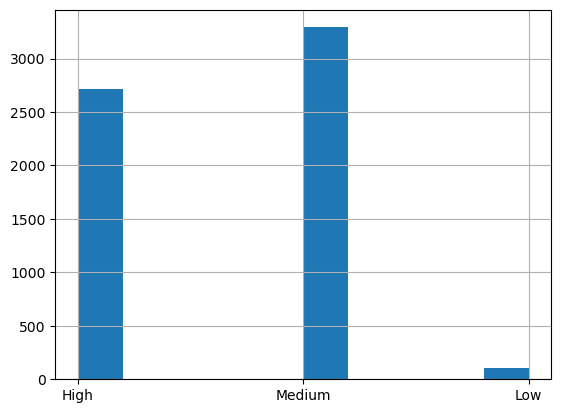

In [43]:
df['route_score'].hist()

We can see that we are dealing with an imbalanced dataset. 

In [91]:
# create a map for the labels - High: 0, Medium: 1, Low = 2
label_dict = {"High": 0, "Medium": 1, "Low": 2}
df['labels'] = df['route_score'].map(label_dict, na_action='ignore')

In [92]:
# features
X = df.loc[:, df.columns.difference(['routeID', 'route_score', 'labels'])].values
# labels
y = df.loc[:, 'labels']
y = y.values.ravel()

**Multiclass classifier**

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)

# feature scaling - standardize the features
scaler = StandardScaler()
scaler.fit(X_train)
# scale training data
X_train = scaler.transform(X_train)
# Train a linear regression model using the training set
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)


# feature scaling - standardize the features
X_test = scaler.transform(X_test)
# predictions
y_test_pred = lr.predict(X_test)
# Classification Report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.65      0.55      0.59       272
           1       0.66      0.76      0.71       330
           2       0.75      0.30      0.43        10

    accuracy                           0.66       612
   macro avg       0.69      0.54      0.58       612
weighted avg       0.66      0.66      0.65       612



Trying under and oversampling

In [94]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

RANDOM_STATE = 42
ros = SMOTE(random_state=RANDOM_STATE)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# this is just to check if now the 2 classes are equally distributed
print(sorted(Counter(y_resampled).items()))

# feature scaling - standardize the features
scaler = StandardScaler()
scaler.fit(X_resampled)
# scale training data
X_resampled = scaler.transform(X_resampled)
# Train a linear regression model using the training set
lr = LogisticRegression(max_iter=1000)
lr.fit(X_resampled, y_resampled)


# feature scaling - standardize the features
X_test = scaler.transform(X_test)
# predictions
y_test_pred = lr.predict(X_test)
# Classification Report
print(classification_report(y_test, y_test_pred))

[(0, 2633), (1, 2633), (2, 2633)]
              precision    recall  f1-score   support

           0       0.46      0.31      0.37       272
           1       0.53      0.34      0.41       330
           2       0.01      0.20      0.02        10

    accuracy                           0.32       612
   macro avg       0.33      0.28      0.27       612
weighted avg       0.49      0.32      0.39       612



In [95]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

RANDOM_STATE = 42
ros = RandomUnderSampler(random_state=RANDOM_STATE)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# this is just to check if now the 2 classes are equally distributed
print(sorted(Counter(y_resampled).items()))

# feature scaling - standardize the features
scaler = StandardScaler()
scaler.fit(X_resampled)
# scale training data
X_resampled = scaler.transform(X_resampled)
# Train a linear regression model using the training set
lr = LogisticRegression(max_iter=1000)
lr.fit(X_resampled, y_resampled)


# feature scaling - standardize the features
X_test = scaler.transform(X_test)
# predictions
y_test_pred = lr.predict(X_test)
# Classification Report
print(classification_report(y_test, y_test_pred))

[(0, 82), (1, 82), (2, 82)]
              precision    recall  f1-score   support

           0       0.43      0.62      0.51       272
           1       0.39      0.04      0.08       330
           2       0.03      0.50      0.05        10

    accuracy                           0.31       612
   macro avg       0.28      0.39      0.21       612
weighted avg       0.40      0.31      0.27       612



**Binary classifier**


In this approach, we will treat the data is a binary dataset by mapping the high class to 0 and medium and low to 1.

In [96]:
# create a map for the labels - Binary classification: High: 0, Medium/Low = 1
label_dict = {"High": 0, "Medium": 1, "Low": 1}
df['labels'] = df['route_score'].map(label_dict, na_action='ignore')

In [97]:
# features
X = df.loc[:, df.columns.difference(['routeID', 'route_score', 'labels'])].values
# labels
y = df.loc[:, 'labels']
y = y.values.ravel()

Fitting a logistic regression model using the historical data

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)

# feature scaling - standardize the features
scaler = StandardScaler()
scaler.fit(X_train)
# scale training data
X_train = scaler.transform(X_train)
# Train a linear regression model using the training set
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)


# feature scaling - standardize the features
X_test = scaler.transform(X_test)
# predictions
y_test_pred = lr.predict(X_test)
# Classification Report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.65      0.52      0.58       272
           1       0.67      0.78      0.72       340

    accuracy                           0.67       612
   macro avg       0.66      0.65      0.65       612
weighted avg       0.66      0.67      0.66       612



Trying over and under sampling:

In [88]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

RANDOM_STATE = 42
ros = SMOTE(random_state=RANDOM_STATE)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# this is just to check if now the 2 classes are equally distributed
print(sorted(Counter(y_resampled).items()))

# feature scaling - standardize the features
scaler = StandardScaler()
scaler.fit(X_resampled)
# scale training data
X_resampled = scaler.transform(X_resampled)
# Train a linear regression model using the training set
lr = LogisticRegression(max_iter=1000)
lr.fit(X_resampled, y_resampled)


# feature scaling - standardize the features
X_test = scaler.transform(X_test)
# predictions
y_test_pred = lr.predict(X_test)
# Classification Report
print(classification_report(y_test, y_test_pred))

[(0, 2715), (1, 2715)]
              precision    recall  f1-score   support

           0       0.50      0.59      0.54       272
           1       0.61      0.52      0.56       340

    accuracy                           0.55       612
   macro avg       0.55      0.55      0.55       612
weighted avg       0.56      0.55      0.55       612



In [90]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

RANDOM_STATE = 42
ros = RandomUnderSampler(random_state=RANDOM_STATE)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# this is just to check if now the 2 classes are equally distributed
print(sorted(Counter(y_resampled).items()))

# feature scaling - standardize the features
scaler = StandardScaler()
scaler.fit(X_resampled)
# scale training data
X_resampled = scaler.transform(X_resampled)
# Train a linear regression model using the training set
lr = LogisticRegression(max_iter=1000)
lr.fit(X_resampled, y_resampled)


# feature scaling - standardize the features
X_test = scaler.transform(X_test)
# predictions
y_test_pred = lr.predict(X_test)
# Classification Report
print(classification_report(y_test, y_test_pred))

[(0, 2174), (1, 2174)]
              precision    recall  f1-score   support

           0       0.36      0.26      0.30       272
           1       0.52      0.64      0.57       340

    accuracy                           0.47       612
   macro avg       0.44      0.45      0.44       612
weighted avg       0.45      0.47      0.45       612



In [89]:
from imblearn.combine import SMOTETomek
from collections import Counter

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

RANDOM_STATE = 42
ros = SMOTETomek(random_state=RANDOM_STATE)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# this is just to check if now the 2 classes are equally distributed
print(sorted(Counter(y_resampled).items()))

# feature scaling - standardize the features
scaler = StandardScaler()
scaler.fit(X_resampled)
# scale training data
X_resampled = scaler.transform(X_resampled)
# Train a linear regression model using the training set
lr = LogisticRegression(max_iter=1000)
lr.fit(X_resampled, y_resampled)


# feature scaling - standardize the features
X_test = scaler.transform(X_test)
# predictions
y_test_pred = lr.predict(X_test)
# Classification Report
print(classification_report(y_test, y_test_pred))

[(0, 2271), (1, 2271)]
              precision    recall  f1-score   support

           0       0.49      0.65      0.56       272
           1       0.62      0.45      0.52       340

    accuracy                           0.54       612
   macro avg       0.55      0.55      0.54       612
weighted avg       0.56      0.54      0.54       612



Trying SelectKBest:

In [99]:
from sklearn.feature_selection import SelectKBest, chi2

X = df.loc[:, df.columns.difference(['routeID', 'route_score', 'labels'])]
y = df.loc[:, "labels"]

select = SelectKBest(score_func=chi2, k=20)
z = select.fit_transform(X, y)

print("After selecting best 3 features:", z.shape)
filter = select.get_support()
features = X.columns
print("Selected best 20:")
print(features[filter])

After selecting best 3 features: (6112, 20)
Selected best 20:
Index(['max_planned_service_time', 'max_time_btw_stops', 'mean_time_btw_stops',
       'median_time_btw_stops', 'ratio_delivery_time_stops',
       'ratio_package_volume_planned_service',
       'ratio_package_volume_violation_late_total_time',
       'ratio_package_volume_violation_time',
       'ratio_travel_time_packages_count', 'ratio_travel_time_stops',
       'route_size', 'total_delivery_time', 'total_planned_service_time',
       'travel_time', 'violation_avg_time', 'violation_early_avg_time',
       'violation_early_total_time', 'violation_late_avg_time',
       'violation_late_total_time', 'violation_total_time'],
      dtype='object')
